In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
from sklearn.metrics import roc_auc_score

In [37]:
import pandas as pd

In [38]:
X = pd.read_csv("train.csv")

In [39]:
y = X.pop("Survived")

In [40]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Skip the categorical variables for now.

Replace the empty ages with the mean age.

In [41]:
X["Age"].fillna(X.Age.mean(), inplace=True)

In [42]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [43]:
#Get numeric variables and ignore categorical variables
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22,1,0,7.2500
1,2,1,38,1,0,71.2833
2,3,3,26,0,0,7.9250
3,4,1,35,1,0,53.1000
4,5,3,35,0,0,8.0500


In [44]:
model = RandomForestRegressor(n_estimators=100, oob_score = True, random_state=42)

# Use only numeric variables
model.fit(X[numeric_variables], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [45]:
# Produces the R^2 value
model.oob_score_

0.13420772645642021

In [46]:
y_oob = model.oob_prediction_
print "c-stat: ", roc_auc_score(y, y_oob)

c-stat:  0.738634305862


Benchmark

Descriptive Statistics on Categorical Variables

In [47]:
def describe_categorical(X):
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [48]:
describe_categorical(X)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [49]:
X.drop(["Name", "Ticket", "PassengerId"], axis=1, inplace=True)

In [50]:
#Change the Cabin Variable to to be only the first letter or None
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return "None"
X["Cabin"] = X.Cabin.apply(clean_cabin)

In [51]:
categorical_variables = ['Sex', 'Cabin', 'Embarked']

for variable in categorical_variables:
    #Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    #Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    #Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)
    

In [52]:
#Look at all the columns in the dataset
def printall(X,max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
printall(X)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
887,1,19.000000,0,0,30.0000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
888,3,29.699118,1,2,23.4500,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
889,1,26.000000,0,0,30.0000,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [53]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state =42)
model.fit(X,y)
print "C-stat: ", roc_auc_score(y, model.oob_prediction_)

C-stat:  0.864772739377



Variable Importance Measures

In [54]:
import matplotlib

In [55]:
%matplotlib inline

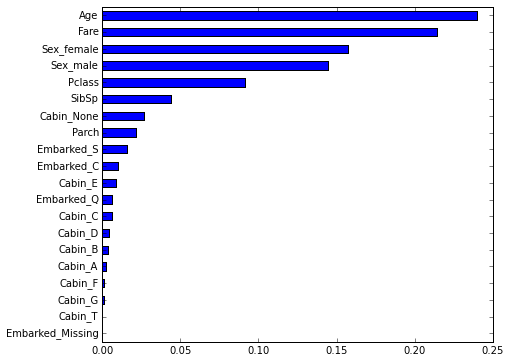

In [56]:
#Show all the variables importance in isolation
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind='barh', figsize=(7,6));

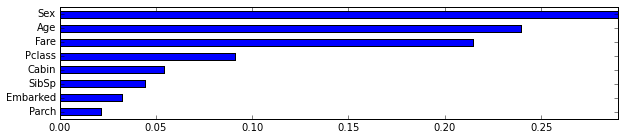

In [57]:
# Complex version that shows the summary view

def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    By Mike Bernico
    
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.iteritems() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results.sort(axis=1)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))
    
graph_feature_importances(model, X.columns, summarized_columns=categorical_variables)

In [58]:
X.drop(["Embarked_Missing", "Cabin_T"], axis=1, inplace=True)

Parameter tests
Parameters to test
Parameters that will make your model better
n_estimators: The number of trees in the forest. Choose as high of a number as your computer can handle.
max_features: The number of features to consider when looking for the best split. Try ["auto", "None", "sqrt", "log2", 0.9, and 0.2]
min_samples_leaf: The minimum number of samples in newly created leaves.Try [1, 2, 3]. If 3 is the best, try higher numbers such as 1 through 10.
Parameters that will make it easier to train your model
n_jobs: Determines if multiple processors should be used to train and test the model. Always set this to -1 and %%timeit vs. if it is set to 1. It should be much faster (especially when many trees are trained).

n_jobs

In [59]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)
model.fit(X, y)

1 loops, best of 3: 1.76 s per loop


In [60]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)

1 loops, best of 3: 1.16 s per loop


n_estimators

30 trees
C-stat:  0.854757187443

50 trees
C-stat:  0.861361433334

70 trees
C-stat:  0.861587788536

75 trees
C-stat:  0.86219761608

80 trees
C-stat:  0.862738205562

85 trees
C-stat:  0.863230861002

90 trees
C-stat:  0.863398630152

95 trees
C-stat:  0.863313414076

100 trees
C-stat:  0.863545095282

900 trees
C-stat:  0.86209642199

990 trees
C-stat:  0.862759509581

995 trees
C-stat:  0.862724890551

1000 trees
C-stat:  0.862692934522

1500 trees
C-stat:  0.862599729439

2000 trees
C-stat:  0.862783476603



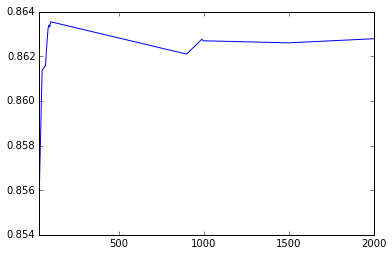

In [61]:
results = []
n_estimator_options = [30, 50, 70, 75, 80, 85, 90, 95, 100, 900, 990, 995, 1000, 1500, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X, y)
    print trees, "trees"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, n_estimator_options).plot();

max_features

auto option
C-stat:  0.862692934522

None option
C-stat:  0.862692934522

sqrt option
C-stat:  0.862658315491

log2 option
C-stat:  0.862658315491

0.9 option
C-stat:  0.862969886769

0.2 option
C-stat:  0.863092384878



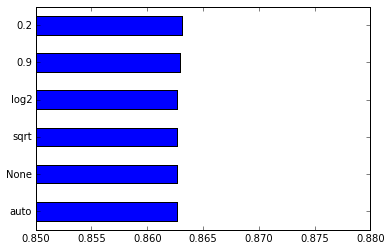

In [62]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X, y)
    print max_features, "option"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.85,.88));

min_samples_leaf

1 min samples
C-stat:  0.862692934522

2 min samples
C-stat:  0.869672663748

3 min samples
C-stat:  0.87165926352

4 min samples
C-stat:  0.873366248043

5 min samples
C-stat:  0.874423459986

6 min samples
C-stat:  0.874061291663

7 min samples
C-stat:  0.873454127121

8 min samples
C-stat:  0.871925563758

9 min samples
C-stat:  0.869337125449

10 min samples
C-stat:  0.867526283833



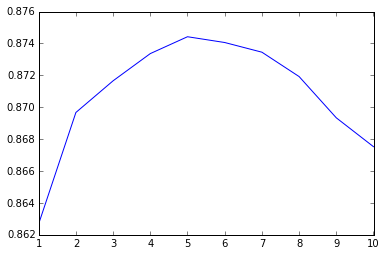

In [63]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto", 
                                  min_samples_leaf=min_samples)
    model.fit(X, y)
    print min_samples, "min samples"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, min_samples_leaf_options).plot();

In [30]:
model = RandomForestRegressor(n_estimators=1000, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features="auto", 
                              min_samples_leaf=5)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print "C-stat: ", roc

C-stat:  0.874423459986


5 max_leaf_node
C-stat:  0.820937057276

10 max_leaf_node
C-stat:  0.837173382759

50 max_leaf_node
C-stat:  0.874247701829

55 max_leaf_node
C-stat:  0.874242375824

60 max_leaf_node
C-stat:  0.874476720033

65 max_leaf_node
C-stat:  0.874434111995

70 max_leaf_node
C-stat:  0.87442878599

90 max_leaf_node
C-stat:  0.87442878599

100 max_leaf_node
C-stat:  0.87442878599

200 max_leaf_node
C-stat:  0.87442878599



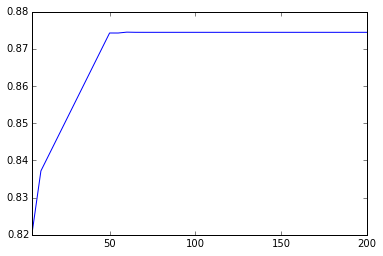

In [64]:
results = []
max_leaf_node_options = [5, 10, 50, 55, 60, 65, 70, 90, 100, 200]

for max_leaf_node in max_leaf_node_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto", 
                                  min_samples_leaf=5,
                                  max_leaf_nodes=max_leaf_node)
    model.fit(X, y)
    print max_leaf_node, "max_leaf_node"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, max_leaf_node_options).plot();

In [65]:
model = RandomForestRegressor(n_estimators=1000, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features="auto", 
                              min_samples_leaf=5,
                              max_leaf_nodes=60)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print "C-stat: ", roc

C-stat:  0.874476720033


Slight improvement from Jason's Code.

Jason's Code produces a C-stat of: 0.874258353838, 
while in my code I added a few additional parameters
and so it produces a C-state of: 0.874476720033.